In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyclifford as pc
import gymnasium as gym
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
import pyclifford as pc
from pyclifford.utils import mask, condense, pauli_diagonalize1,stabilizer_measure
from pyclifford.paulialg import Pauli, pauli, PauliMonomial, pauli_zero
from pyclifford.stabilizer import (StabilizerState, CliffordMap,
    zero_state, identity_map, clifford_rotation_map, random_clifford_map)

In [3]:
def random_layers(N_QUBITS,HALF_DEPTH):
    random_layers=[]
    for i in range (int(HALF_DEPTH)):
        random_layer=[]
        if i%2==0:
            for j in range (int(np.floor(N_QUBITS/2))):
                gate=pc.CliffordGate(j*2,j*2+1)
                gate.set_forward_map(pc.random_clifford_map(2))
                random_layer.append(gate)
            random_layers.append(random_layer)
        elif i%2==1:
            for j in range (int(np.floor(N_QUBITS/2))):
                gate=pc.CliffordGate(j*2+1,(j*2+2)%N_QUBITS)
                gate.set_forward_map(pc.random_clifford_map(2))
                random_layer.append(gate)
            random_layers.append(random_layer)
    return random_layers

In [4]:
def measure_layers(N_QUBITS,HALF_DEPTH,theta):
    measure_layers=[]
    for i in range (int(HALF_DEPTH)):
        measure_layer=[]
        for j in range (int(N_QUBITS)):
            if theta[-i + HALF_DEPTH - 1][j]==1:
                measure_layer.append(j)
        measure_layers.append(measure_layer)
    return measure_layers

In [5]:
def create_circuit(N_QUBITS,HALF_DEPTH,random_layers,measure_layers):
    circ = pc.circuit.Circuit(N_QUBITS)
    for i in range(int(HALF_DEPTH)):
        for j in range(int(np.floor(N_QUBITS/2))):
            circ.take(random_layers[i][j])
        if measure_layers[i]!=[]:
            qubits=tuple(measure_layers[i])
            circ.measure(*qubits)
            
    return circ

In [6]:
def averaged_EE(state_final):
    EE_positions=[]
    for i in range(0,state_final.N):
        EE_positions.append([int(i),int(i+1)%state_final.N])
        
    EE_list=[]
    for i in range(0,len(EE_positions)):
        EE_list.append(state_final.entropy(EE_positions[i]))
    
    averaged_EE=np.mean(EE_list)
        
    return averaged_EE #, EE_positions, EE_list

In [7]:
def penalty(x,penalty_slope):
    return 2*(0.5-(1/(1+np.exp(-penalty_slope*x))-0.5))

In [8]:
class Disentangler(gym.Env):
    """
    Reinforcement learning environment for the disentangler.
    """
    
    def __init__(self, n_qubits, half_depth, positive_reward, penalty_slope):
        super(Disentangler, self).__init__()
        
        self.N_QUBITS = n_qubits
        self.HALF_DEPTH = half_depth
        self.DEPTH = 2*half_depth
        self.positive_reward = positive_reward
        self.penalty_slope = penalty_slope
        
        self.action_space = gym.spaces.Discrete(self.N_QUBITS * self.HALF_DEPTH)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.HALF_DEPTH, self.N_QUBITS), dtype=np.int8)

        self.random_layers=random_layers(self.N_QUBITS,self.HALF_DEPTH)
        self.theta = np.zeros((self.HALF_DEPTH, self.N_QUBITS), dtype=np.int8)
        self.measure_layers=measure_layers(self.N_QUBITS,self.HALF_DEPTH,self.theta)
        
    def step(self, action):
        # Initialize reward and done
        reward = 0
        done = False
        truncate = False

        # Apply the action
        h = np.zeros(self.N_QUBITS * self.HALF_DEPTH, dtype=np.int8)
        h[action] = 1
        h = h.reshape((self.HALF_DEPTH, self.N_QUBITS))
        self.theta = (self.theta + h) % 2

        # Calculate entropy (assumes circuit is a predefined function)
        self.measure_layers=measure_layers(self.N_QUBITS, self.HALF_DEPTH, self.theta)
        circ = create_circuit(self.N_QUBITS, self.HALF_DEPTH, self.random_layers, self.measure_layers)

        state_initial = pc.stabilizer.zero_state(self.N_QUBITS)
        state_final = circ.forward(state_initial)

        entropy = averaged_EE(state_final)

        
        if entropy == 0:
            m_per_layer = [np.sum(layer) for layer in self.theta]
            cost = [m_per_layer[i]*penalty(i,self.penalty_slope) for i in range(self.HALF_DEPTH)]
            reward = self.positive_reward - np.sum(cost)#/(self.N_QUBITS*self.DEPTH)
            done = True
        
        # Return the state, reward, done flag, truncate flag, and info
        info = {}
        return self.theta, reward, done, truncate, info
    
    def return_entropy(self):
        # Calculate entropy (assumes circuit is a predefined function)
        self.measure_layers=measure_layers(self.N_QUBITS, self.HALF_DEPTH, self.theta)
        circ = create_circuit(self.N_QUBITS, self.HALF_DEPTH, self.random_layers, self.measure_layers)

        state_initial = pc.stabilizer.zero_state(self.N_QUBITS)
        state_final = circ.forward(state_initial)

        entropy = averaged_EE(state_final)
        
        return entropy
        
    
    def reset(self, seed=None):
        # Seed the random number generator if a seed is provided
        if seed is not None:
            np.random.seed(seed)
        
        # Reset the state to an all-zero matrix
        self.theta = np.zeros((self.HALF_DEPTH, self.N_QUBITS), dtype=np.int8)

        # Reset the random layers to another random layers
        self.random_layers=random_layers(self.N_QUBITS,self.HALF_DEPTH)
        
        info = {}
        return self.theta, info
    
    def render(self):
        print()

    def close(self):
        # Optional: Implement any cleanup
        pass


In [11]:
# ppo parameters
ts = 0.5*1e6
lr = 0.001
#ec = 5
ec_list=[0.01,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]

# circuit parameters
N_QUBITS=10
#N_QUBITS=[2,3,4,5,6,7,8,9,10,15,20,25,30]

HALF_DEPTH=2
DEPTH=int(2*HALF_DEPTH)
#HALF_DEPTH=[2,3,4,5,6,7,8,9,10,15,20,25,30]
#DEPTH=[int(2*HALF_DEPTH[i]) for i in range(np.size(HALF_DEPTH))]

positive_reward = 50
penalty_slope = 0

num_full_learning = 1

In [12]:
#This part is to check the stability of learning
model_set=[[] for i in range(np.size(ec_list))]

for i in range(np.size(ec_list)):
    ec = ec_list[i]
    print("ec",'=',ec)
    for j in range(num_full_learning):
        ec = ec_list[i]
        print("num_full_learning",'=',j)
        env = Disentangler(N_QUBITS,HALF_DEPTH,positive_reward,penalty_slope)

        env.reset()
        model = PPO('MlpPolicy', env, verbose=0, tensorboard_log="./tensorboard_files", learning_rate=lr, ent_coef=ec)

        model.learn(total_timesteps=ts, tb_log_name="{N_QUBITS}x{HALF_DEPTH}_tb_{ts}_pr_{positive_reward}_ps_{penalty_slope}".format(N_QUBITS=N_QUBITS, HALF_DEPTH=HALF_DEPTH, ts=ts, positive_reward=positive_reward, penalty_slope=penalty_slope))
        model_path = "./models/{N_QUBITS}x{HALF_DEPTH}_tb_{ts}_pr_{positive_reward}_ps_{penalty_slope}".format(N_QUBITS=N_QUBITS, HALF_DEPTH=HALF_DEPTH, ts=ts, positive_reward=positive_reward, penalty_slope=penalty_slope)
        model_set[i].append(model_path)
        model.save(model_path)
        print("learning done")
        


ec = 0.01
num_full_learning = 0
learning done
ec = 0.1
num_full_learning = 0
learning done
ec = 0.2
num_full_learning = 0
learning done
ec = 0.3
num_full_learning = 0
learning done
ec = 0.4
num_full_learning = 0
learning done
ec = 0.5
num_full_learning = 0
learning done
ec = 1
num_full_learning = 0
learning done
ec = 2
num_full_learning = 0
learning done
ec = 3
num_full_learning = 0
learning done
ec = 4
num_full_learning = 0
learning done
ec = 5
num_full_learning = 0
learning done


In [13]:
#Evaluating the model

rewards_list = [[[] for i in range(num_full_learning)]for j in range(np.size(ec_list))]
measurements_list = [[[] for i in range(num_full_learning)]for j in range(np.size(ec_list))]
num_measurements_list =[[[] for i in range(num_full_learning)]for j in range(np.size(ec_list))]

avg_rewards_over_ep=[[] for i in range(np.size(ec_list))]
avg_lens_per_ep_over_ep=[[] for i in range(np.size(ec_list))]

avg_rews_over_learnings = []
avg_lens_per_ep_over_learnings = []

var_rews_over_learnings = []
var_lens_per_ep_over_learnings = []

for i in range(np.size(ec_list)):
    print("ec",'=',ec_list[i])
    for j in range(num_full_learning):
        model_path=model_set[j][0]
        epmodel = PPO.load(model_path)
        print("evaluation of num_full_learning",'=',j)
#    rewards, lengths = evaluate_policy(model, env, n_eval_episodes=1000, return_episode_rewards=True, warn=False)
        episodes = 1000
        for _ in range(episodes):
            obs, _ = env.reset()
            done = False
    
            while not done:
                action, state = model.predict(obs)
                obs, rewards, done, truncate, info = env.step(action)

            rewards_list[i][j].append(rewards)
            measurements_list[i][j].append(obs)
            num_measurements_list[i][j].append(np.sum(obs))
        
        avg_rewards_over_ep[i].append(np.mean(rewards_list[i][j]))
        avg_lens_per_ep_over_ep[i].append(np.mean(num_measurements_list[i][j]))
    
    avg_rews_over_learnings.append(np.mean(avg_rewards_over_ep[i]))
    avg_lens_per_ep_over_learnings.append(np.mean(avg_lens_per_ep_over_ep[i]))
    
    var_rews_over_learnings.append(np.var(avg_rewards_over_ep[i]))
    var_lens_per_ep_over_learnings.append(np.var(avg_lens_per_ep_over_ep[i]))
    

ec = 0.01
evaluation of num_full_learning = 0
ec = 0.1
evaluation of num_full_learning = 0
ec = 0.2
evaluation of num_full_learning = 0
ec = 0.3
evaluation of num_full_learning = 0
ec = 0.4
evaluation of num_full_learning = 0
ec = 0.5
evaluation of num_full_learning = 0
ec = 1
evaluation of num_full_learning = 0
ec = 2
evaluation of num_full_learning = 0
ec = 3
evaluation of num_full_learning = 0
ec = 4
evaluation of num_full_learning = 0
ec = 5
evaluation of num_full_learning = 0


In [14]:
measurements_list

[[[array([[0, 0, 1, 0, 1, 0, 0, 1, 0, 1],
          [1, 0, 1, 0, 0, 1, 1, 0, 1, 0]], dtype=int8),
   array([[1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 0, 1, 0, 1, 1, 0, 0, 1]], dtype=int8),
   array([[1, 0, 1, 0, 1, 0, 0, 1, 1, 0],
          [0, 1, 1, 0, 0, 1, 1, 1, 0, 0]], dtype=int8),
   array([[0, 1, 0, 0, 0, 0, 0, 1, 1, 1],
          [1, 1, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8),
   array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8),
   array([[1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
          [1, 1, 0, 1, 1, 0, 0, 0, 0, 0]], dtype=int8),
   array([[1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8),
   array([[0, 0, 1, 0, 0, 1, 0, 1, 1, 1],
          [1, 0, 0, 0, 1, 0, 0, 0, 1, 0]], dtype=int8),
   array([[0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
          [0, 1, 1, 0, 0, 0, 1, 1, 1, 0]], dtype=int8),
   array([[0, 1, 1, 0, 1, 1, 1, 0, 0, 1],
          [1, 0, 0, 0, 0, 1, 0, 1, 0, 1]], dtype=int8),
   array([[0, 0, 1, 

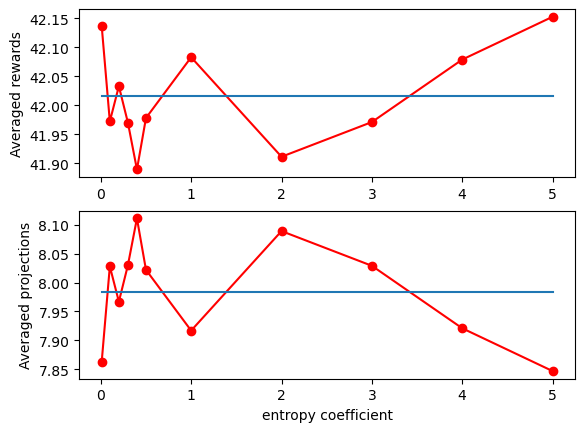

In [15]:
#x_axis = [i+1 for i in range(num_full_learning)], np.size(all_avg_rews)
#have the different learning, put avg_all and variance_all(np.var())

x_axis = [ec_list[i] for i in range(np.size(avg_rews_over_learnings))]

avg_rews_over_ec = np.mean(avg_rews_over_learnings)              
avg_lens_per_ep_ec = np.mean(avg_lens_per_ep_over_learnings)

y_avg_rews_over_ec =[ avg_rews_over_ec for i in range(np.size(avg_rews_over_learnings)) ]
y_avg_lens_per_ep_ec = [ avg_lens_per_ep_ec for i in range(np.size(avg_lens_per_ep_over_learnings)) ]

                                                      
fig=plt.figure()

plt.subplot(211)
plt.plot(x_axis,avg_rews_over_learnings,'-ro')
plt.plot(x_axis,y_avg_rews_over_ec,'-')
#plt.plot(x_axis,y_var_all_avg_rews,'-ro')
plt.ylabel('Averaged rewards')

plt.subplot(212)
plt.plot(x_axis,avg_lens_per_ep_over_learnings,'-ro')
plt.plot(x_axis,y_avg_lens_per_ep_ec,'-')
plt.xlabel('entropy coefficient')
plt.ylabel('Averaged projections')
 
plt.show()

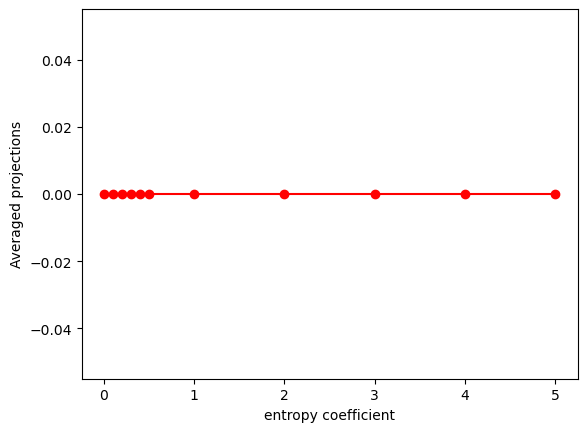

In [16]:
fig=plt.figure()

plt.plot(x_axis,var_rews_over_learnings,'-ro')
#plt.plot(x_axis,y_var_lens_per_ep_ec,'-')
plt.xlabel('entropy coefficient')
plt.ylabel('Averaged projections')
 
plt.show()

In [ ]:
averaged_entropies = []
episodes=1000
for measurement in measurements_list[0][0]:
    entropies = []
    for _ in range(episodes):
        ran_lay=random_layers(N_QUBITS,HALF_DEPTH)
        mea_lay=measure_layers(N_QUBITS,HALF_DEPTH,measurement)
        circ = create_circuit(N_QUBITS,HALF_DEPTH,ran_lay,mea_lay)
        state_initial = pc.stabilizer.zero_state(N_QUBITS)
        state_final = circ.forward(state_initial)
        entropy = averaged_EE(state_final)
        entropies.append(entropy)
        
    
    averaged_entropies.append(np.mean(entropies))

normalized_averaged_entropies = [float(i)/sum(averaged_entropies) for i in averaged_entropies]
    
plt.figure(figsize=(10,6))
plt.hist(averaged_entropies,density=False)
plt.xlabel('Averaged von Neumann Entropy')
plt.ylabel('Count')
plt.title('Histogram of Averaged von Neumann Entropies')
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
a,b,c=plt.hist(averaged_entropies, density=True, stacked=True)

plt.xlabel('Averaged von Neumann Entropy')
plt.ylabel('Count')
plt.title('Histogram of Averaged von Neumann Entropies')
plt.xticks(rotation=90)
plt.show()

In [ ]:
normalized_a=[i/sum(a) for i in a]
plt.stairs(normalized_a,b)

In [ ]:
averaged_measurements = np.mean(measurements_list[0][0], axis=0)
variance_measurements = np.var(measurements_list[0][0], axis=0)

plt.figure()
plt.imshow(averaged_measurements, cmap="YlGnBu")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(variance_measurements, cmap="hot")
plt.colorbar()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(projection='3d')



averaged_measurements = np.mean(measurements_list[0][0], axis=0)
variance_measurements = np.var(measurements_list[0][0], axis=0)

cord=[[i,j] for i in range (HALF_DEPTH) for j in range (N_QUBITS)]


y=np.transpose([cord[i][0] for i in range (N_QUBITS*HALF_DEPTH)])
x=np.transpose([cord[i][1] for i in range (N_QUBITS*HALF_DEPTH)])
z=np.zeros(N_QUBITS*HALF_DEPTH,int)

width = depth = 0.5

avg_m=[]
for i in range (HALF_DEPTH-1,-1,-1):
    avg_m.append(averaged_measurements[i])
heights=np.concatenate(avg_m)


#plt.xlim(max(x), min(x))

ax.bar3d(x-0.2, y-0.4, z, width, depth, heights, shade=True)
ax.set_box_aspect([int(N_QUBITS/HALF_DEPTH), 1, 1]) 
ax.set_xticks([i for i in range (N_QUBITS)]) 
ax.set_yticks([i for i in range (HALF_DEPTH)]) 

plt.show()

In [ ]:
alpha = [0,0.5,1,4,5]
for aa in alpha:
    x = range(DEPTH)
    y = [penalty(xx,aa) for xx in x]
    plt.plot(x,y)

In [ ]:
theta_star = measurements[0]
theta_star